In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

print('Defining the instructions to show or hide code blocks')
hide_toggle()

Defining the instructions to show or hide code blocks


In [2]:
import numpy  as np
import pandas as pd
import time

# data processing tools
from sklearn.datasets        import load_boston
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics         import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2

# Machine Learning algorithms
from sklearn.linear_model    import LinearRegression
from sklearn.neighbors       import KNeighborsRegressor
from sklearn                 import tree
from sklearn.ensemble        import RandomForestRegressor
from sklearn.neural_network  import MLPRegressor

# visualisation tools
%matplotlib notebook
import matplotlib.pyplot as plt

print('Loading all necessary work packages')
hide_toggle()

Loading all necessary work packages


# Supervised Machine Learning: Predicting house prices in Boston
This example addresses a typical regression problem, namely the prediction of housing prices. The underlying idea here is to find the relationship between average house prices in different neighborhoods of Boston and characteristics of the neighborhoods. The characteristics may be the age of the population, tax rate, distance to important employment centers, crime rate, etc...

The aim is to show the pipeline of a typical Machine Learning workflow, from the loading of the dataset to the assessment of the quality of the prediction. The following steps are addressed:
1. Loading of the dataset and data pre-processing (selection of features and targets, normalization of the data, etc.)
2. Selection of Machine Learning models 
3. Tuning of the hyper-parameters of each model (i.e. the model architecture)
4. Assessment of the results (using different error metrics)

### Definitions:
*Features and targets*
- The inputs to the Machine Learning model are its **features**, and the output is the **prediction** or **label**. 
- In a **supervised** setting, the **target** is the label of the training points, i.e. the "ground truth". 
- It is important that ALL features must be available for the training process and for the application of the model, even when the targets are unknown

*Performance assessment*
- The data (features and targets) is divided into a **training set** and a **test set**. The training set is used to train the algorithm. The separate test set is used to assess the model performance.
- In a **regression** setting, where the target is a continuous variable, the metric used to assess the performance is the mean-squared error (MSE)

*Hyper-parameters and tuning*
- The **hyper-parameters** of the Machine Learning models, which determine its architecture, and are determined during the **tuning** procedure. 
- The most common method for tuning is a trial-and-error approach (try many different values and pick the one which achieves the lowest MSE between the predictions and the targets)
- A **k-fold cross-validation** procedure is used to assess the model performance during tuning: The data is split into *k* random subsets (*folds*), of which *k-1* are used to train the model with a given set of hyper-parameters, and the *kth* fold is used for **validation** (to predict the labels).

More details about the dataset used here can be found at: 
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston

# Part 1: Data loading and pre-processing
## 1.1 Dataset description
A detailed description of the dataset, of all features and the target is given below. Note that this dataset is cleaned, i.e. outliers have been removed and there are no missing values. With a real dataset, data cleaning has to be performed before the modelling procedure.

In [3]:
print(load_boston()['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

## 1.2 Loading and inspection of the data

In [4]:
features = pd.DataFrame( data = load_boston().data,   columns = load_boston().feature_names)
target   = pd.DataFrame( data = load_boston().target, columns = ['MEDV'])

In [5]:
features.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
target.head()

,MEDV
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2


### Distribution of features and target 
The figure below shows the distribution (through histograms) of each of the features and the target. The x-axis shows the value of the respective features, and the y-axis shows the number of data points (samples) with a given value. This inspection is useful to obtain an intuition on the dataset, as it gives an indication of the variance of each feature. 

**Observations**:

1. 'CHAS' (bordering with the river Charles) is a *categorical variable*, which can only be "true" or "false" (0 or 1).
2. The price of the houses is approximately normally distributed around 20,000, with an additional increasing number of houses at around 50,000. It is hence expected that the models perform best for houses at a value of around 20,000.
3. 'CRIM', 'ZN', 'CHAS' and 'B' all have one very high peak, i.e. over 80% of the data has almost or exactly the same value. Frequently, these features with a low variance have a low contribution to the predicted value (*BUT*: this is certaintly not always the case, it is easy to find an example that disproves the statement!)

<IPython.core.display.Javascript object>


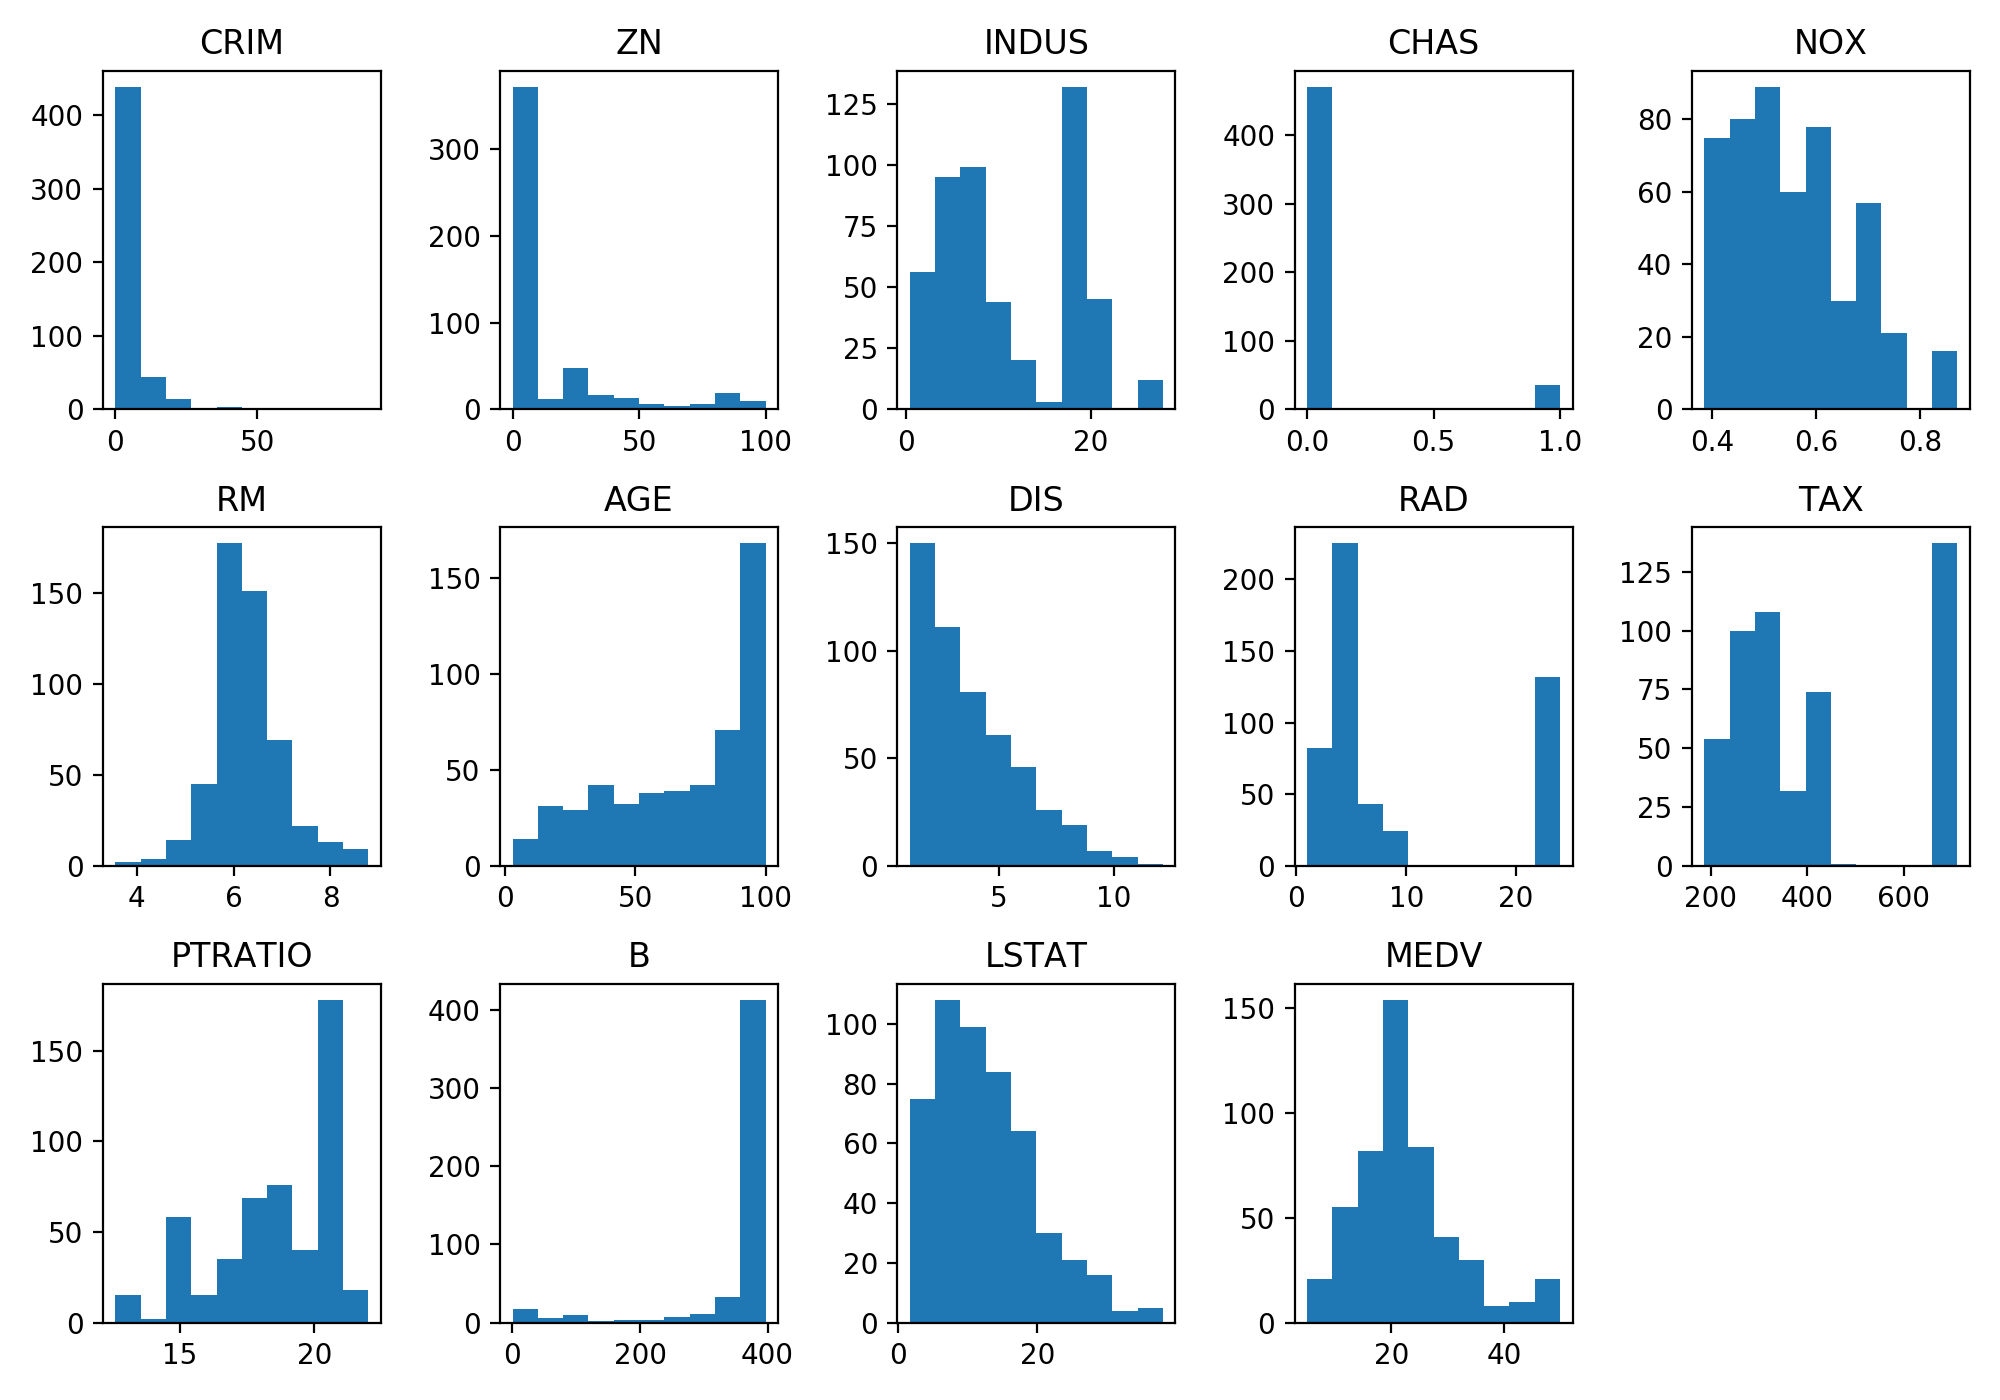

In [25]:
plt.figure(figsize = (10, 7))
for i, name in enumerate(features.columns):
    plt.subplot(3, 5, i+1)
    plt.hist(features[ name ])
    plt.title( name )
plt.subplot(3, 5, i+2)
plt.hist(target.values)
plt.title( 'MEDV' )
plt.tight_layout()
plt.savefig('Features_histogram.png', dpi = 300)

hide_toggle()

### Correlation between features and targets
The figure below shows the correlation between the features and the targets, for each feature separately. The x-axis shows the value of the respective features, and the y-axis shows the value of the target. This inspection is useful to obtain an intuition on the dataset, and on the importance of different features. 

**Observations:**

1. The strongest linear correlation with the mean house price is observed for 'RM' (the number of roofs), and a strong negative correlation is found for 'LSTAT' (percentage of lower status of the population) - these are likely important features.
2. Less strong (pos./neg.) correlations with the average house price can also be observed for DIS (proximity to employment centers), 'INDUS' (proportion of industry buildings) and 'NOX' (pollution measure).
3. The order of magnitude of the features varies strongly between different features, with some being in the range of [0, 1] and others (e.g. 'TAX') ranging up to multiple hundreds. For this reason, **normalization** of the data is important.

<IPython.core.display.Javascript object>


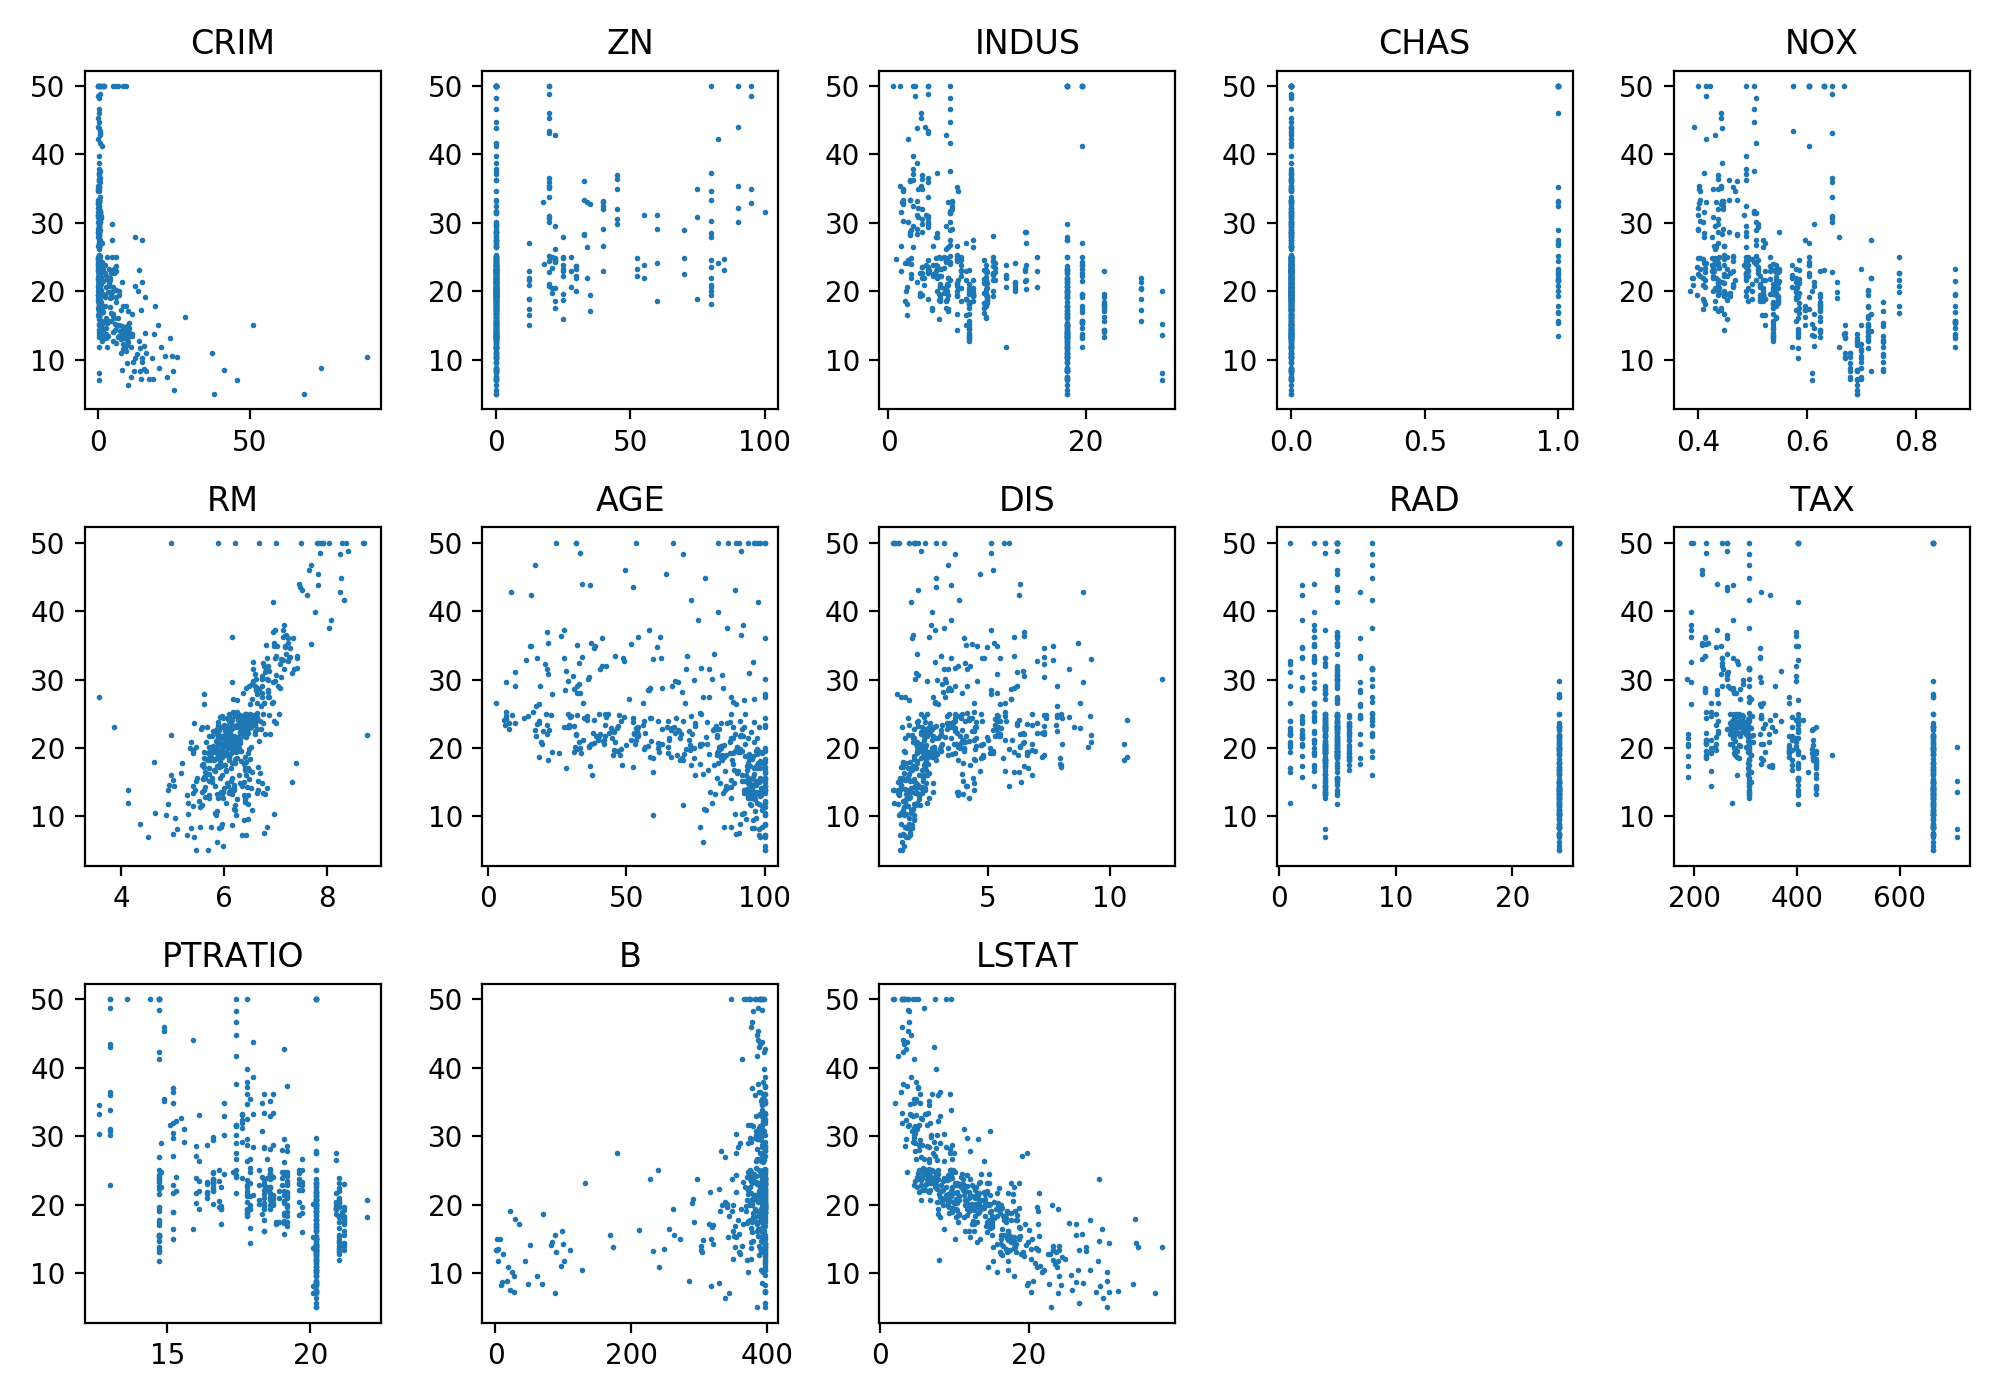

In [24]:
plt.figure(figsize = (10, 7))
for i, name in enumerate(features.columns):
    plt.subplot(3, 5, i+1)
    plt.scatter(features[ name ], target.MEDV, s = 1)
    plt.title( name )
plt.tight_layout()
plt.savefig('Features_vs_target.png', dpi = 300)

hide_toggle()

## 1.3 Split the data into training and test set
The data is now randomly split into a training and test set, whereby the training set is used to tune the Machine Learning model, and the test set is used in step 4 to assess the model performance. In this case, 70% of the datais used for training, and 30% of the data is used for testing.

In [9]:
# Make a train/test split using 30% test size
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30)

## 1.4 Normalization of the dataset
Many of the Machine Learning algorithms require a dataset which is normalized, i.e. which has a mean of 0 and a standard deviation of 1. In the following step we normalize both the features and the targets. The normalization is performed from the sample statistics of the training set, but also applied to the test set.

In [10]:
norm_X  = StandardScaler()
X_train = norm_X.fit_transform(X_train)
X_test  = norm_X.transform(X_test)

In [11]:
norm_y  = StandardScaler()
y_train_norm = norm_y.fit_transform(y_train).reshape((-1))
y_test_norm  = norm_y.transform(y_test).reshape((-1))

# Part 2: Selection of Machine Learning algorithms

We consider 4 different ML algorithms here. They have different complexities, which results in different numbers of hyper-parameters to tune, and different computational times for training and prediction. The algorithms, their advantages and disadvantages are shown below and explained in the following.

<img src="ML_algorithms3.png" width="950" style="float: left;">

***Linear regression*** assumes that the target is a linear function of the inputs. The prediction ($y$) is obtained from a linear combination of the features ($x_i$), which minimizes the residual sum of squares between the target and predicted values. This linear combination is represented by the black line shown in the illustration. Mathematically, this can be expressed as:

$$y = w_0 + w_1 * f_1 + w_2 * f_2 + ... + w_L * f_L$$

where $w_i$ are the weights for each feature, which are computed during model training.

Linear regression is fast, very computationally efficient and requires no tuning of hyper-parameters but shows a low accuracy for non-linear problems.

The documentation for the implementation used here can be found at: https://scikit-learn.org/stable/modules/linear_model.html

***K-nearest neighbor regression*** is an interpolation algorithm, which computes a prediction as the average of the targets of the *k* training samples whose features are closest to the given inputs. The illustration shows an example where $k = 5$. The prediction for the given (yellow) point is the *weighted average* of the targets of the 5 closest points. As the prediction for a new sample depends on the distance of its features to those of the training data, it is very important to normalize the data and to select appropriate features in order to achieve a good performance.

The training dataset works as a look-up table for the predictions, so it is effective for low-dimensional problems but inefficient for large datasets (all the training data is kept and searched every time). 

Different distance metrics can be used to measure the "closeness" of the points. Most frequently, the (normal) Euclidean distance is used. The only hyper-parameter to tune is hence the **number of neighbors (*k*)**.
We call this variable `N_NEIGHBORS`

The documentations is given at: https://scikit-learn.org/stable/modules/neighbors.html

***Random Forest*** is an ensemble algorithm, which consists of a set of decision trees. During training of a decision tree, the data is successively split at each node (circles in the illustration) based on a threshold. The threshold is automatically selected in the training process so as to maximise the difference between the two resulting subsets. The ends of the tree are called *leaf nodes*. Each leaf node contains at least one training data point. The predicted value of a given leaf node is the average of the targets of all training points in this leaf. Each of the *ensemble members* (the $n$ trees) are separately trained in this way. During prediction, each tree passes a data point along the nodes (highlighted in yellow in the illustration) until a leaf node is reached. The prediction of the Random Forest is the average of the predicted values of all the trees.  

It is apopular algorithm due to its good predictive power and high robustness. They require computational power to train, but they are typically fast in the prediction phase. One of the reasons why it works very well, as the structure of the algorithm allows a high degree of randomization (hence the name). The randomization is due to the choice of the training data that is used for each tree, as well as the **number of features that are considered for splitting the data** at each node. This is a hyper-parameter that can be tuned. We call it `MAX_FTRS`.

Another reason for its robustness is the ensemble structure. While individual decision trees are not very good predictors, the fact that a very large number of these are combined results in a very stable algorithm. The size of the Random Forest, i.e. the **number of trees (estimators) in the forest**, is another hyper-parameter. Here, it is called `N_EST`.

Finally, the smoothness of the prediction is determined by the *depth* of the trees, i.e. the total number of nodes in each tree and the number of layers. One hyper-parameter that impacts this is the **minimum number of samples in each leaf node**. We refer to this hyper-parameter as `MIN_LEAF`.

For the documentation, refer to: https://scikit-learn.org/stable/modules/ensemble.html#forest

***Neural Network*** is a very popular algorithm that relies on a structure similar to the human brain. In a neural network, the input features are passed through a set of *hidden layers*. Each node of the hidden layer computes its value by multiplying all of the nodes in the *previous* layer with their weights. The weights are assigned to each *connection*, i.e. each line in the illustration. The output is computed by multiplying the last hidden layer (shown as hidden layer $n$) with the *output weighths* and applying an output function (indicated as $f$). Simular to the linear regression, all weights are found during training, using the so-called *back-propagation* principle. 

The structure of the neural network, i.e. the **size and number of the hidden layers**, are the hyper-parameters that need to be determined during training. As each layer may have a different size, the possible number of combinations is large, which complicates the tuning procedure. For many applications, one or two layers are a good starting point. The variable that contains this network structure is called `MLP_LAYERS`.

Neural networks have gained enormous popularity, as they have shown to perform very well on image classification tasks and for natural language processing. For these tasks, huge networks are being constructed, with many hidden layers. It is not untypical that these can take days and many GPUs to train. 
For many smaller problems, however, neural networks do not generally outperform other algorithms. They often require a much more intensive tuning procedure in order to obtain a network that is just marginally better than, for example, Random Forests. Additionally, neural networks are often very sensitive to small changes in the hyper-parameters or in the training dataset. They are real "black boxes", so it can be difficult to understand *why* the algorithm gives a certain prediction. 

Documentation: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

### *IMPORTANT*: There is no better or worse algorithm, it depends on the context and the problem at hand.

# Part 3: Hyper-parameter tuning

In [12]:
# pred_train = cross_val_predict(RF, X_train, y_train, cv = 5)

# Part 4: Performance assessment
After the tuning procedure, a final choice of hyper-parameters for each model should be selected. These should be the hyper-parameters which lead to the lowest mean-squared error. Then, each of the Machine Learning model is trained with these hyper-parameters, and the error metrics (shown below) are assessed for the test set. This is useful for the comparison between the different models. Additionally, the prediction and targets for the test set can be plotted. This visual analysis permits to identify, for example, regions in which a model overestimates or underestimates the data.

## 4.1 Define the selected error metrics
The metrics shown here are:
1. Root-mean-squared error (**RMSE**), i.e. the square-root of the squared difference between targets and predictions
2. Mean absolute error (**MAE**), i.e. the average absolute difference between targets and predictions (and its value as percentage of the target)
3. Mean bias error (**MBE**), i.e. the average difference between targets and predictions (and its value as percentage of the target)
4. R2 coefficient of determination (**R2**), representing the "goodness of fit" between the targets and predictions

The code below is the definition of the selected metrics and does not need to be changed.

In [13]:
def notnan( x ):
    return x[~np.isnan(x)]

# DEFINE THE ERROR MEASUREMENTS
error = {
    'RMSE': lambda y, t: np.sqrt(mse(t,y)),
    'MAE' : lambda y, t: mae(t,y),
    'MBE' : lambda y, t: np.mean(t - y),
    'MAE (% of target)': lambda y, t: mae(np.ones(len(y)), notnan(y/t)) * 100,
    'MBE (% of target)': lambda y, t: np.mean(1 - notnan(y/t)) * 100,
    'R2'  : lambda y, t: r2(t,y)
}

def get_errors(true, pred, label = ''):
    # create a pandas series with errors and print them
    true = true.reshape((-1,1))
    pred = pred.reshape((-1,1))
    
    err_series = pd.Series(data = np.zeros(len(error)), index = error.keys())
    for key, val in error.items():
        # print('%s %s: %f' %(label, key, val(pred, true)))
        err_series[ key ] = val(pred, true)
        
    return err_series

print('Define error metrics')
hide_toggle()

Define error metrics


## 4.2 Define the final values of the selected hyper-parameters
These are the "outputs" of the hyper-parameter tuning (see Part 3)

In [14]:
# K-nearest neighbors
N_NEIGHBORS = 10

# Random Forest
N_EST    = 500
MAX_FTRS = 3
MIN_LEAF = 3

# Neural Network
MLP_LAYERS = (100, 20)

## 4.3 Train and test the Machine Learning models
The Machine Learning models are all collected in a *dictionary*. The training and testing (the prediction on the test set and computation of the error) is performed for each entry in the dictionary, i.e. for each ML model, inside a *for-loop*.

In [15]:
estimators = {}
estimators['Linear regression'  ] = LinearRegression( n_jobs = -1 )
estimators['K-nearest neighbors'] = KNeighborsRegressor( n_neighbors = N_NEIGHBORS, n_jobs = -1 )
estimators['Random Forest'      ] = RandomForestRegressor( n_estimators = N_EST, max_features = MAX_FTRS, 
                                                           min_samples_leaf = MIN_LEAF, n_jobs = -1 )
estimators['Neural network'     ] = MLPRegressor( hidden_layer_sizes = MLP_LAYERS )

In [16]:
prediction = {}
errors     = pd.DataFrame(data = [])

for name, est in estimators.items():
    est.fit(X_train, y_train_norm)
    prediction[ name ] = norm_y.inverse_transform( est.predict(X_test) )
    errors[ name ]     = get_errors(y_test.values, prediction[ name ])

/Applications/anaconda2/envs/py3_new/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## 4.4 Analyze and compare the errors
The table below shows the different error metrics for each of the four algorithms that were analyzed here. The MAE and MBE are also shown as percentage of the target value, for an easier interpretability. 

**Interpretation of results**: 
The Random Forest and Neural Networks show the overall best performance. They achieve a mean absolute error of 10-11%, which can be interpreted as "accuracy" of 10-11%. All models slightly underestimate the actual house prices by 2-3%, as the MBE is negative for all models. The scatterplots show clearly the good fit for the Random Forest and Neural Networks, while Linear Regression and the K-nearest Neighbor prediction are scattered further apart. Note also that the grey line indicates the "ideal" regression line (R2 = 1.0)

In [17]:
errors

,Linear regression,K-nearest neighbors,Random Forest,Neural network
RMSE,4.727146,4.535963,3.535632,2.817643
MAE,3.428712,2.875461,2.400470,2.088772
MBE,-0.023700,0.565855,0.052808,0.090856
MAE (% of target),18.971944,14.821814,13.655733,11.104730
MBE (% of target),-5.882127,-4.068182,-5.461767,-1.365282
R2,0.761429,0.780336,0.866539,0.915240


<IPython.core.display.Javascript object>


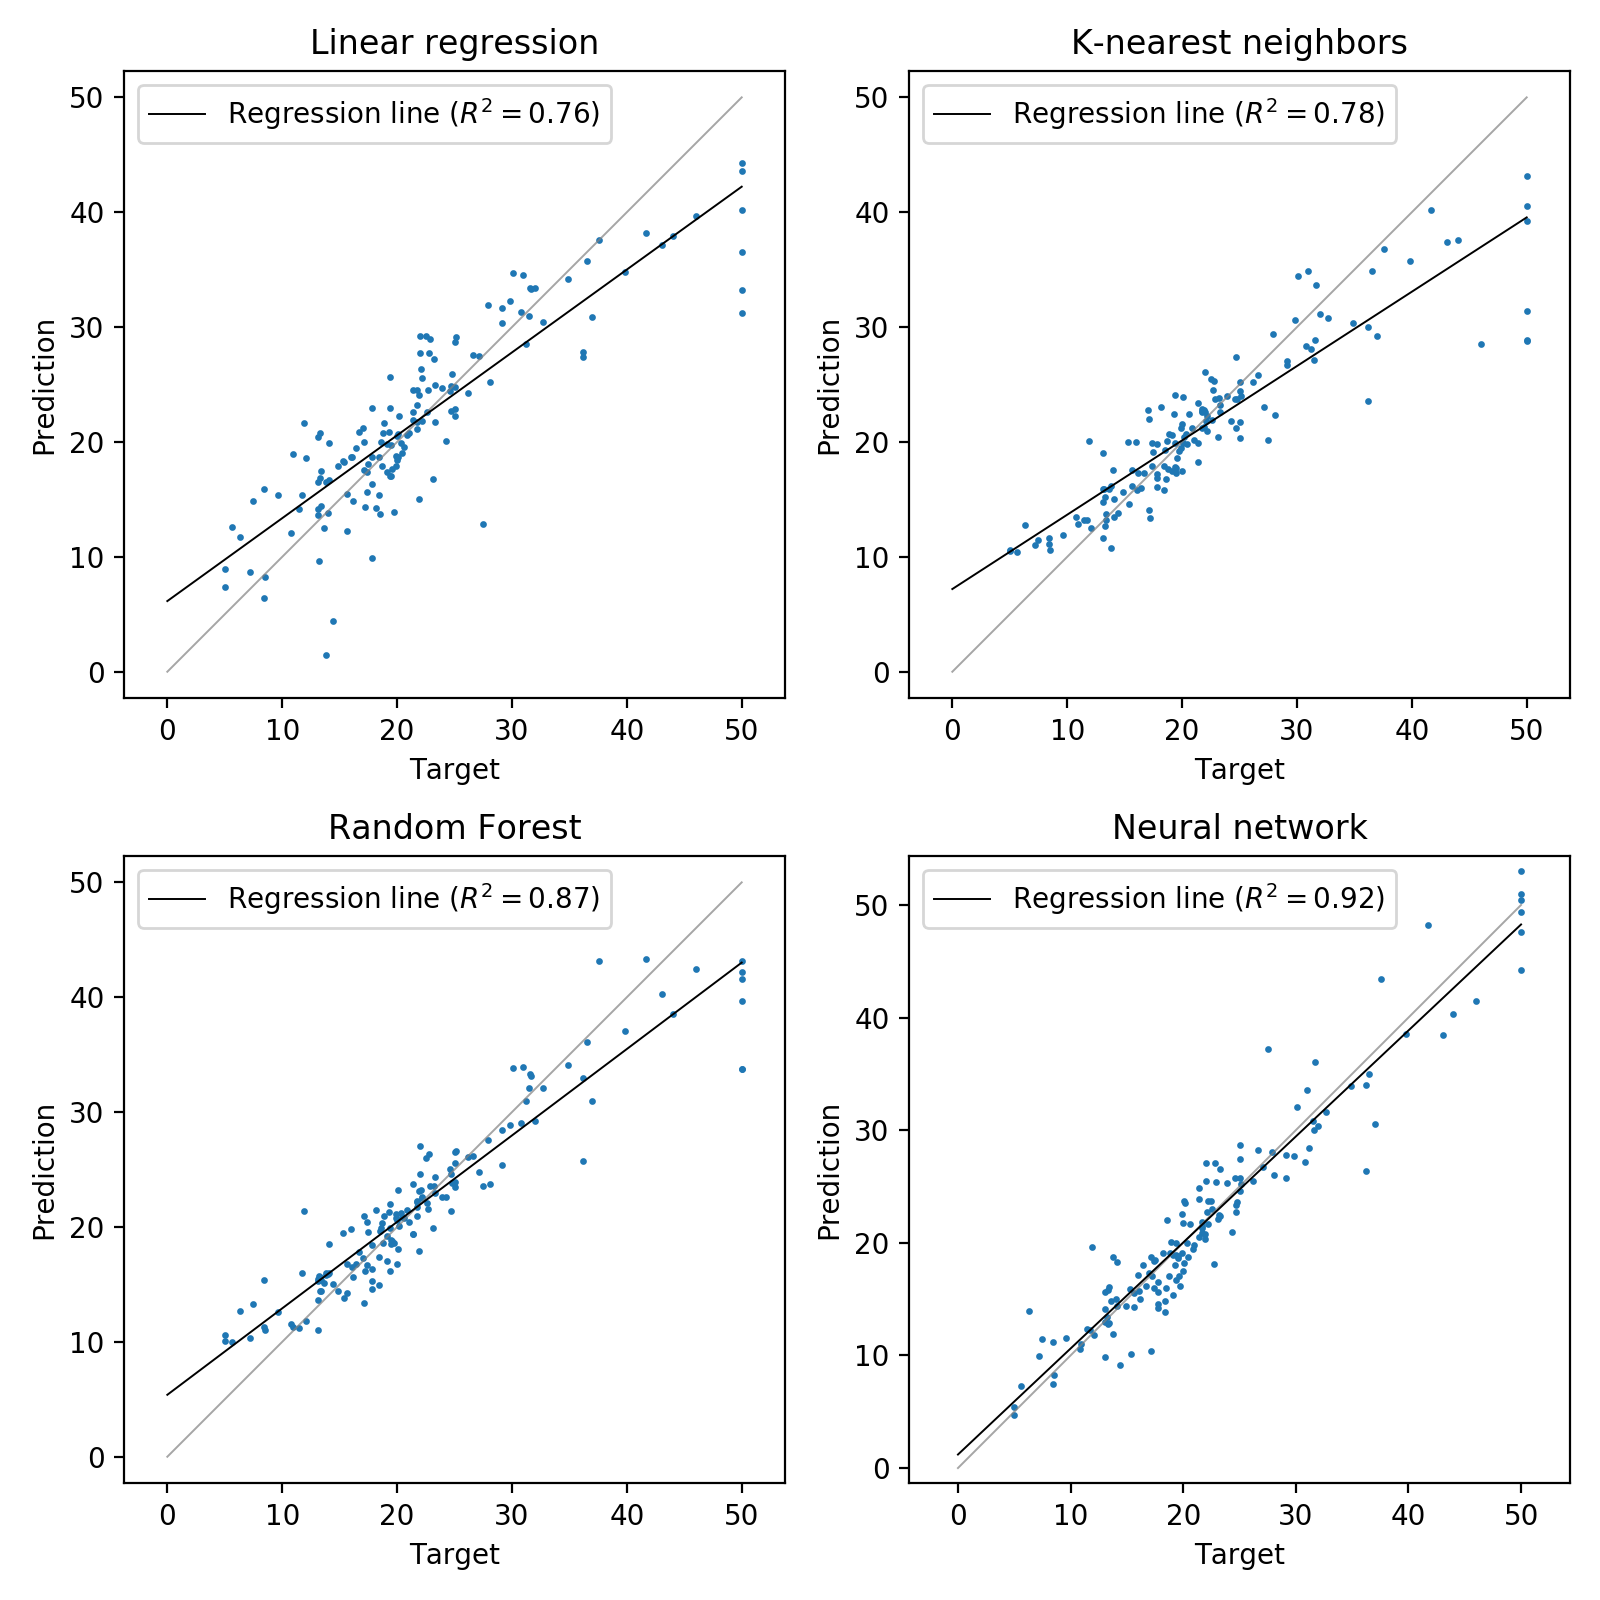

In [23]:
plt.figure( figsize = (8, 8))
i = 1
MIN_VAL = 0
MAX_VAL = 50

for name, pred in prediction.items():
    # compute the regression line
    LIN = LinearRegression( n_jobs = -1 )
    LIN.fit( y_test.values, pred )

    # plot the data
    plt.subplot(2, 2, i)
    plt.scatter(y_test.values, pred, s = 2)
    plt.plot( [ MIN_VAL, MAX_VAL ], [ MIN_VAL, MAX_VAL ], c = 'grey', alpha= 0.7, lw = 0.7)
    plt.plot( [ MIN_VAL, MAX_VAL ], LIN.predict( np.asarray([MIN_VAL, MAX_VAL]).reshape(-1, 1) ), 
              c = 'k', lw = 0.7, label = 'Regression line ($R^2 = %.2f$)' %(errors.loc['R2', name]))
    # format plot
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.title( name )
    plt.axis('equal')
    plt.legend(loc = 2)
    i += 1
plt.tight_layout()
plt.savefig('Target_vs_prediction.png', dpi = 300)

hide_toggle()

# *Extra*: Feature importance analysis using Random Forests
To better understand the features used in the model, and possibly to reduce the number of features by selecting only the relevant ones, the **feature importance** score available through the Random Forest algorithm is a very useful tool. 
The feature importance is a measure of how much each of the features contributes to the predicted result, and is established during the training of the Random Forest algorithm. More details can be found here (https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

**Observations:**
The feature importances are shown in the graph below. The two most important features are 'LSTAT' and 'RM'. This is not surprising, as these are the features with the highest correlation with the house prices, which were observed in Section 1.2. The 4 features with the lowest importance show very small values, and can probably be removed from the dataset without loss of accuracy. Amongst these are 'ZN', 'CHAS', which are all features with low variances, as the histograms showed.

In [19]:
# train a Random Forest algorithm and obtain the R2 score for the test set
RF       = RandomForestRegressor(n_estimators = 500, n_jobs = -1)
RF.fit(X_train, y_train_norm)
r2_score = RF.score(X_test, y_test_norm)

In [20]:
# obtain the importance scores from the Random Forest estimator and rank them by highest importance
n_features = X_train.shape[1]
importance = np.mean([tree.feature_importances_ for tree in RF.estimators_],axis=0)
ind = np.argsort(importance)[-n_features:]

print('Compute importance scores for each feature from the Random Forest estimator and rank them by highest importance')
hide_toggle()

Compute importance scores for each feature from the Random Forest estimator and rank them by highest importance


<IPython.core.display.Javascript object>


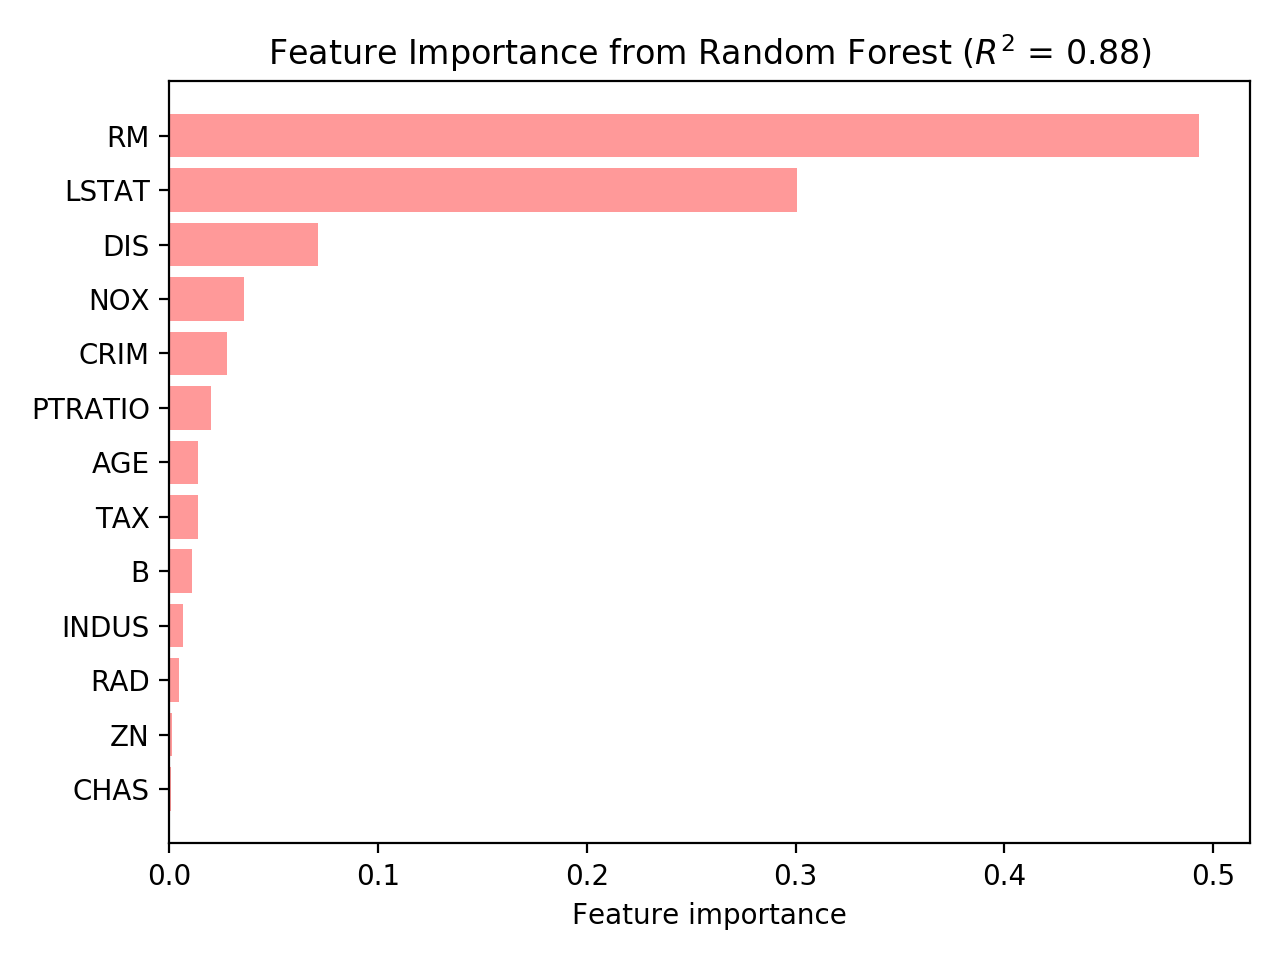

In [22]:
plt.figure()
ax = plt.axes()
plt.title("Feature Importance from Random Forest ($R^2$ = %.2f)" %(r2_score)) 
plt.barh(range(n_features),importance[ind], color="r", alpha=0.4, align="center", capsize = 2)
plt.yticks(range(n_features), features.columns[ind])
plt.ylim([-1, len(ind)])
plt.xlabel('Feature importance')
plt.tight_layout()
plt.show()
plt.savefig('Feature_importance.png', dpi=300)

hide_toggle()